# 인물사진을 직접 만들어봅시다!!

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [6]:
import matplotlib.image as mpimg

img_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/'

cat_path = img_path + 'cat.jpg'
dog_path = img_path + 'dog.jpg'
my_pic1_path = img_path + 'my_pic1.JPG'
my_pic2_path = img_path + 'my_pic2.JPG'

cat = cv2.imread(cat_path)
dog = cv2.imread(dog_path)
my_pic1 = cv2.imread(my_pic1_path)
my_pic2 = cv2.imread(my_pic2_path)

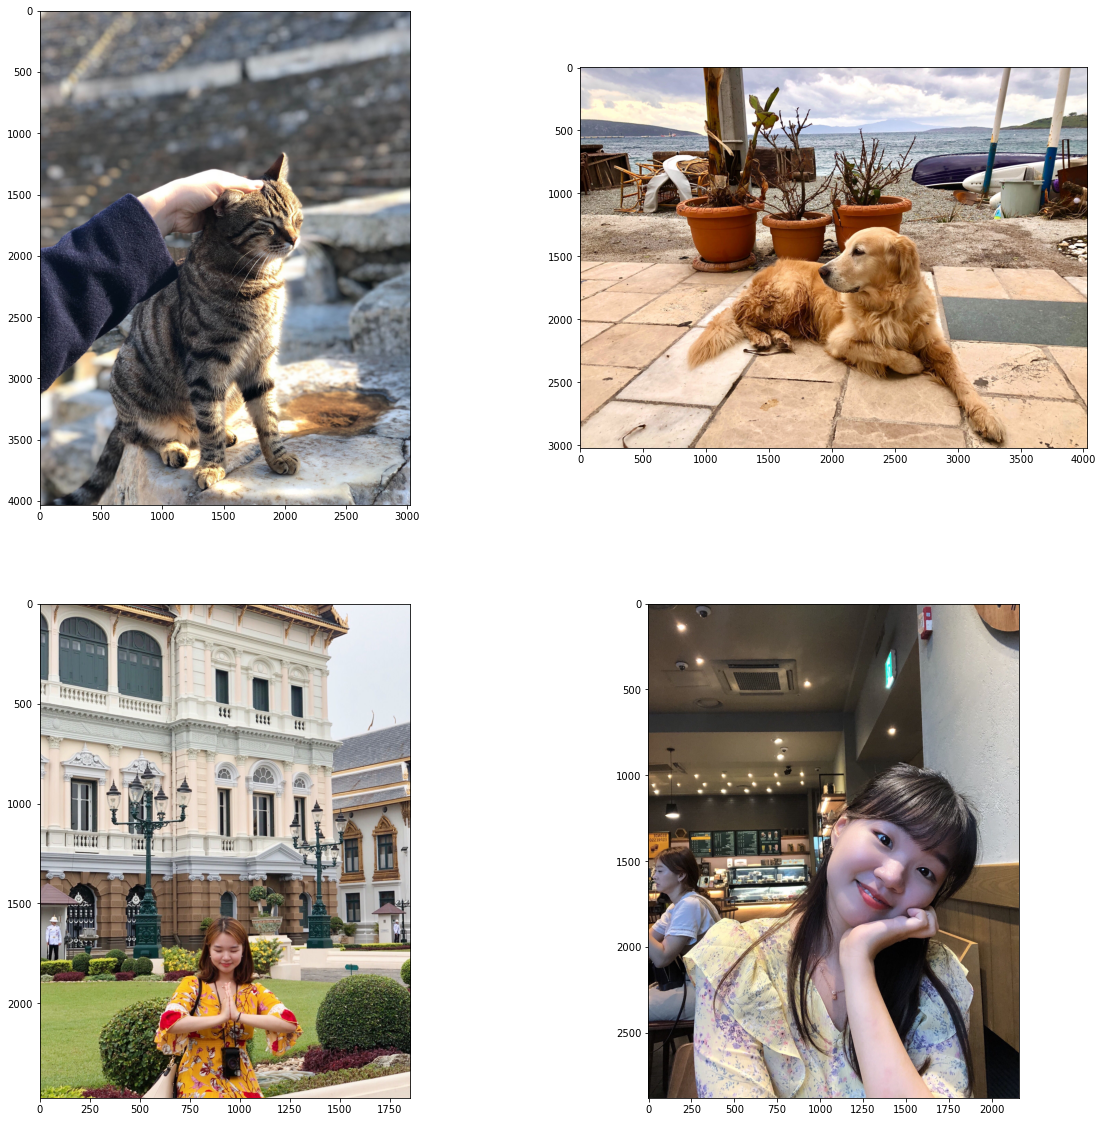

In [16]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(cv2.cvtColor(dog, cv2.COLOR_BGR2RGB))

ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(cv2.cvtColor(my_pic1, cv2.COLOR_BGR2RGB))

ax4 = fig.add_subplot(2, 2, 4)
ax4.imshow(cv2.cvtColor(my_pic2, cv2.COLOR_BGR2RGB))


plt.show()

잘 불러와집니다~ 

In [19]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

계속해서 갑시다!

In [20]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [38]:
#cat
cat_resized, seg_map = MODEL.run(cat)
print (cat.shape, cat_resized.shape, seg_map.max())

(4032, 3024, 3) (513, 384, 3) 15


In [36]:
# dog
dog_resized, seg_map2 = MODEL.run(dog)
print(dog.shape, dog_resized.shape, seg_map2.max())

(3024, 4032, 3) (384, 513, 3) 16


In [25]:
# my_pic1
my_pic1_resized, seg_map3 = MODEL.run(my_pic1)
print(my_pic1.shape, my_pic1_resized.shape, seg_map3.max())

(2473, 1855, 3) (513, 384, 3) 15


In [26]:
# my_pic2
my_pic2_resized, seg_map4 = MODEL.run(my_pic2)
print(my_pic2.shape, my_pic2_resized.shape, seg_map4.max())

(2880, 2160, 3) (513, 384, 3) 15


In [27]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

/home/aiffel0039/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aiffel0039/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


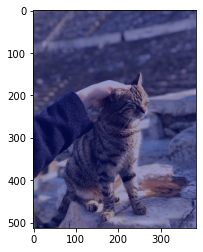

In [40]:
cat_show = cat_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0 )
img_mask1 = seg_map * (255/seg_map.max()) # 255 norm
img_mask1 = img_mask1.astype(np.uint8)
color_mask1 = cv2.applyColorMap(img_mask1, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask1, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

헉 제대로 불러와지지 않네요. 다른 것도 한번 살펴볼까요?

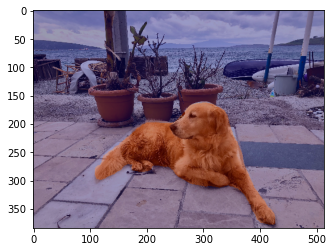

In [37]:
dog_show = dog_resized.copy()
seg_map2 = np.where(seg_map2 == 12, 12, 0)
img_mask2 = seg_map2 * (255/seg_map2.max()) # 255 normalization
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
dog_show = cv2.addWeighted(dog_show, 0.6, color_mask2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(dog_show, cv2.COLOR_BGR2RGB))
plt.show()

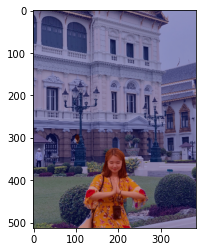

In [41]:
my_pic1_show = my_pic1_resized.copy()
seg_map3 = np.where(seg_map3 == 15, 15, 0)
img_mask3 = seg_map3 * (255/seg_map3.max()) # 255 normalization
img_mask3 = img_mask3.astype(np.uint8)
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)
my_pic1_show = cv2.addWeighted(my_pic1_show, 0.6, color_mask3, 0.35, 0.0)

plt.imshow(cv2.cvtColor(my_pic1_show, cv2.COLOR_BGR2RGB))
plt.show()

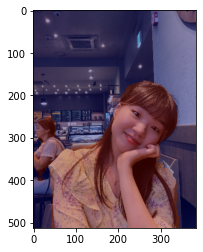

In [42]:
my_pic2_show = my_pic2_resized.copy()
seg_map4 = np.where(seg_map4 == 15, 15, 0)
img_mask4 = seg_map4 * (255/seg_map4.max()) # 255 normalization
img_mask4 = img_mask4.astype(np.uint8)
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)
my_pic2_show = cv2.addWeighted(my_pic2_show, 0.6, color_mask4, 0.35, 0.0)

plt.imshow(cv2.cvtColor(my_pic2_show, cv2.COLOR_BGR2RGB))
plt.show()

고양이 빼고 잘 나오네요!!

### 원래 크기로 복원하기

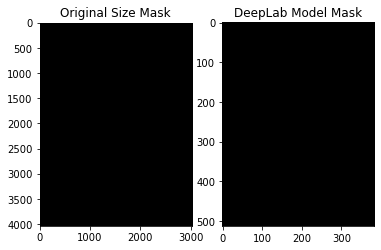

In [43]:
# cat
cat_mask_up = cv2.resize(img_mask1, cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask1, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

고양이는 원래 잘 안불러와졌으니까.. 8ㅅ8 멍멍이를 봅시다.

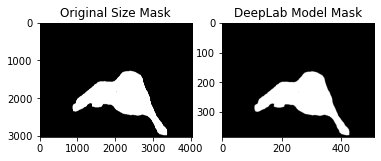

In [45]:
# dog
dog_mask_up = cv2.resize(img_mask2, dog.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, dog_mask_up = cv2.threshold(dog_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(dog_mask_up, cmap=plt.cm.binary_r)
ax.set_title("Original Size Mask")

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title("DeepLab Model Mask")

plt.show()

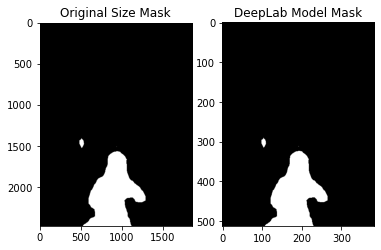

In [50]:
# my_pic1
my_pic1_mask_up = cv2.resize(img_mask3, my_pic1.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, my_pic1_mask_up = cv2.threshold(my_pic1_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(my_pic1_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

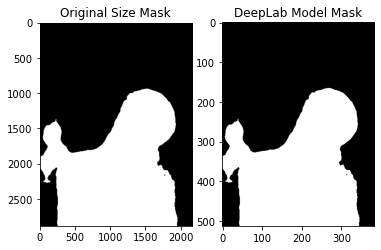

In [51]:
# my_pic2
my_pic2_mask_up = cv2.resize(img_mask4, my_pic2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, my_pic2_mask_up = cv2.threshold(my_pic2_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(my_pic2_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask4, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

조금 이상하지만 그래도 잘 되네요..! 배경을 그럼 이제 흐리게 해봅시다.

## 배경 흐리게하기

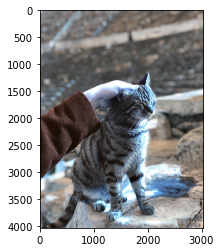

In [52]:
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg = cv2.bitwise_and(cat, cat_bg_mask)
plt.imshow(cat_bg)
plt.show()

이 이미지를 블러처리하면 됩니다.

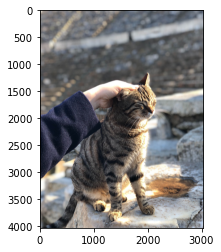

In [59]:
cat_bg_blur = cv2.blur(cat_bg, (13, 13))
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

아까부터 고양이는 잘 안되었죠? 나머지들도 한번 해봅시다.

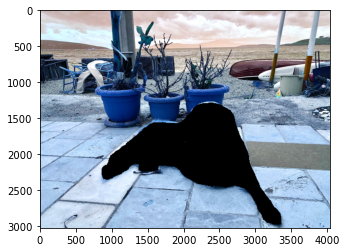

In [56]:
dog_mask_color = cv2.cvtColor(dog_mask_up, cv2.COLOR_GRAY2BGR)
dog_bg_mask = cv2.bitwise_not(dog_mask_color)
dog_bg = cv2.bitwise_and(dog, dog_bg_mask)
plt.imshow(dog_bg)
plt.show()

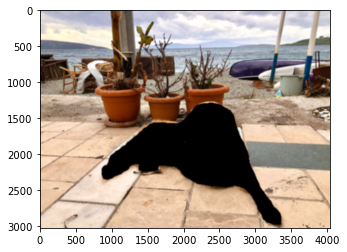

In [70]:
dog_bg_blur = cv2.blur(dog_bg, (20, 20))
plt.imshow(cv2.cvtColor(dog_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

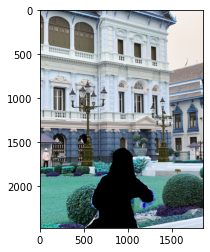

In [57]:
my_pic1_color = cv2.cvtColor(my_pic1_mask_up, cv2.COLOR_GRAY2BGR)
my_pic1_bg_mask = cv2.bitwise_not(my_pic1_color)
my_pic1_bg = cv2.bitwise_and(my_pic1, my_pic1_bg_mask)
plt.imshow(my_pic1_bg)
plt.show()

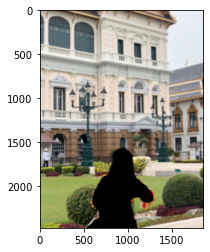

In [68]:
my_pic1_bg_blur = cv2.blur(my_pic1_bg, (15, 15))
plt.imshow(cv2.cvtColor(my_pic1_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

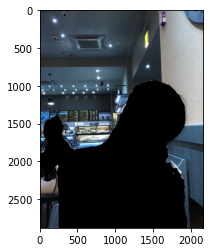

In [58]:
my_pic2_color = cv2.cvtColor(my_pic2_mask_up, cv2.COLOR_GRAY2BGR)
my_pic2_bg_mask = cv2.bitwise_not(my_pic2_color)
my_pic2_bg = cv2.bitwise_and(my_pic2, my_pic2_bg_mask)
plt.imshow(my_pic2_bg)
plt.show()

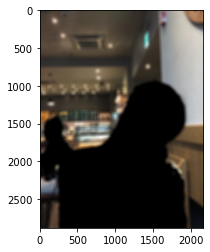

In [65]:
my_pic2_bg_blur = cv2.blur(my_pic2_bg, (50, 50))
plt.imshow(cv2.cvtColor(my_pic2_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 흐린 배경과 원본 영상 합성

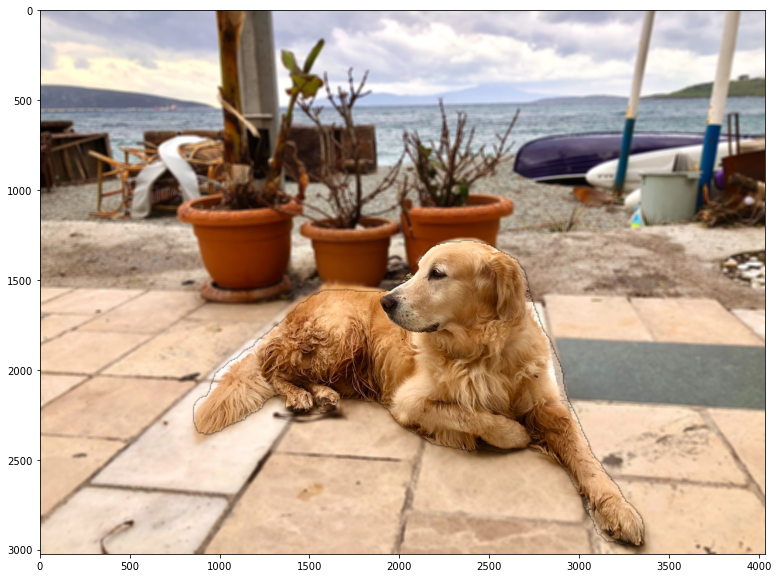

In [72]:
plt.figure(figsize=(20, 10))
dog_concat = np.where(dog_mask_color ==255, dog, dog_bg_blur)
plt.imshow(cv2.cvtColor(dog_concat, cv2.COLOR_BGR2RGB))
plt.show()

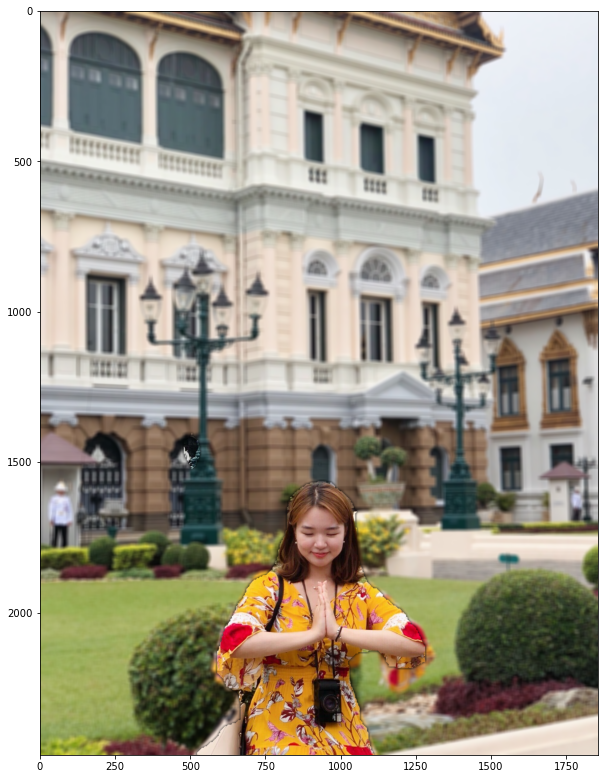

In [76]:
plt.figure(figsize=(10, 30))
my_pic1_concat = np.where(my_pic1_color==255, my_pic1, my_pic1_bg_blur)
plt.imshow(cv2.cvtColor(my_pic1_concat, cv2.COLOR_BGR2RGB))
plt.show()

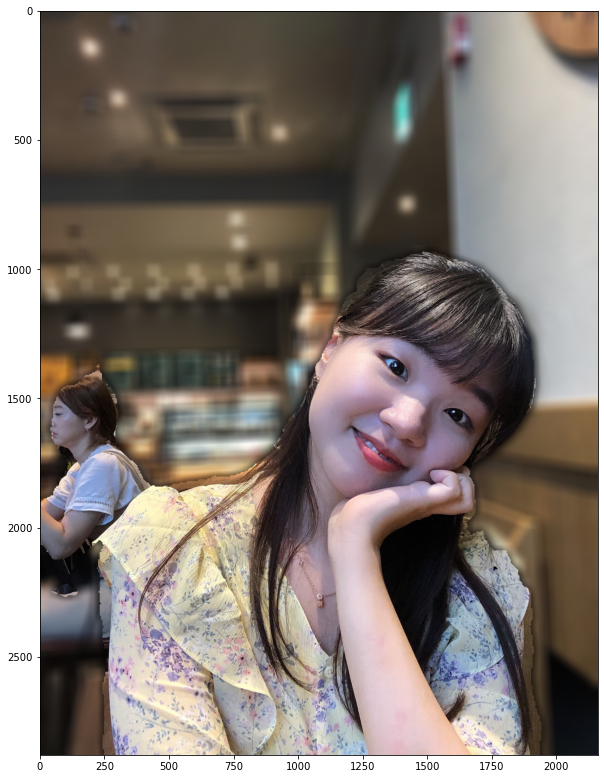

In [75]:
plt.figure(figsize=(10, 30))
my_pic2_concat = np.where(my_pic2_color==255, my_pic2, my_pic2_bg_blur)
plt.imshow(cv2.cvtColor(my_pic2_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Conclusion

대체로 잘 분류하는 것 같지만, 문제가 좀 있습니다. 마지막 사진의 경우에는 옆에 있는 사람하고 같이 나왔어요.

세그멘테이션 그 자체의 한계일수도 있습니다.


### 세그멘테이션의 한계

Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

### 피사계 심도 이해하기

우선 피사계심도의 개념부터 명확히 이해해 봅시다.

참고자료 : <https://ggyul.tistory.com/12>

### 3D Depth Camera 활용하기

카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

참고자료 : <https://m.blog.naver.com/panoptics/221336152952>

### 깊이 영상(Depth image) 활용하기

하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

참고자료 : <https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6>
참고자료 : <https://sites.google.com/view/struct2depth>

### IR(적외선)을 활용한 사례

구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

참고자료 : <https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html>

